In [99]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import *
from dots.models import MLP, DeepLinear
from dots.dots import *
from dots.utils import get_device, entropy, plot_dots_stats, random_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep linear models


In [31]:
deep_linear = DeepLinear(1, 1, hidden=5, hidden_size=10)
deep_linear.count_params()

471

Parameters in model: 471


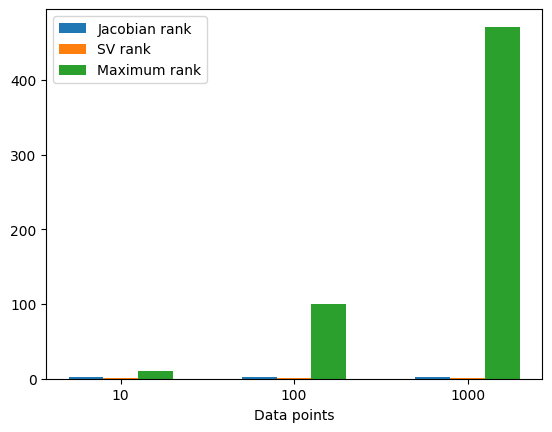

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axs2 = [axs2]
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


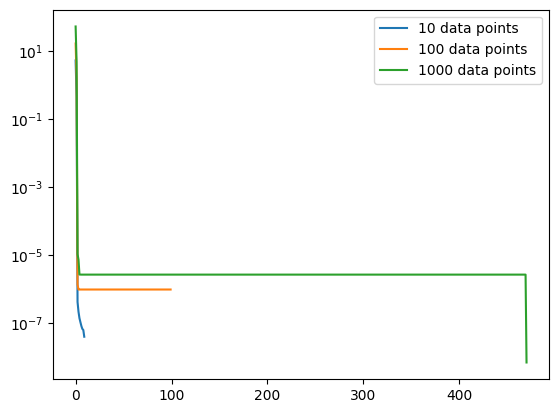

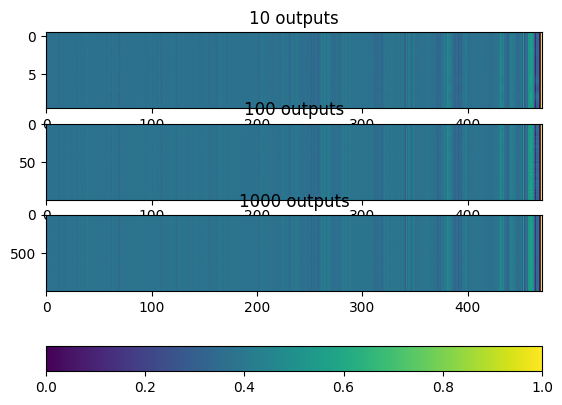

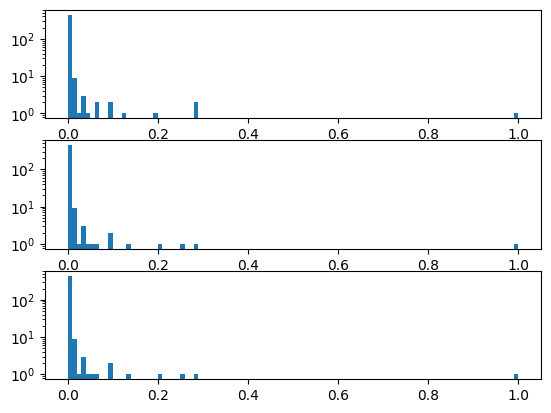

In [106]:
plot_dots_stats(
    deep_linear,
    [
        random_batch(10, 1),
        random_batch(100, 1),
        random_batch(1000, 1)
    ]
)

Parameters in model: 501


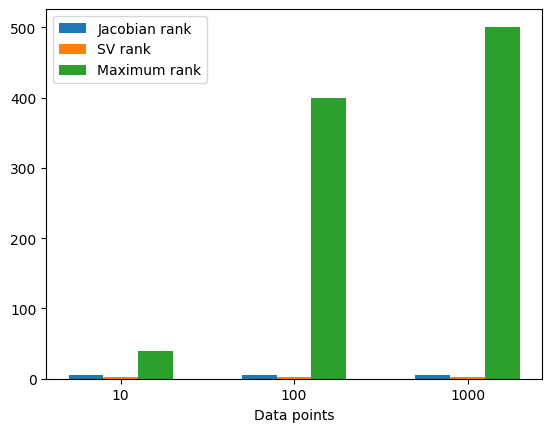

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axs2 = [axs2]
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


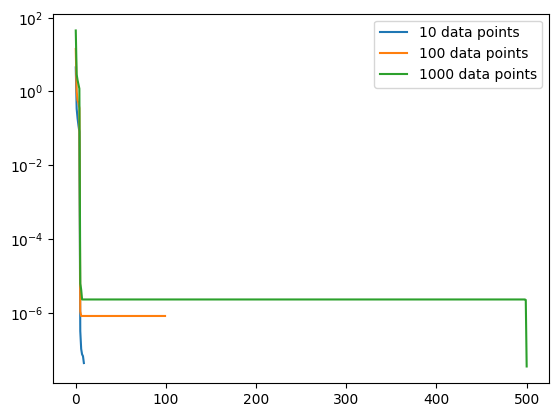

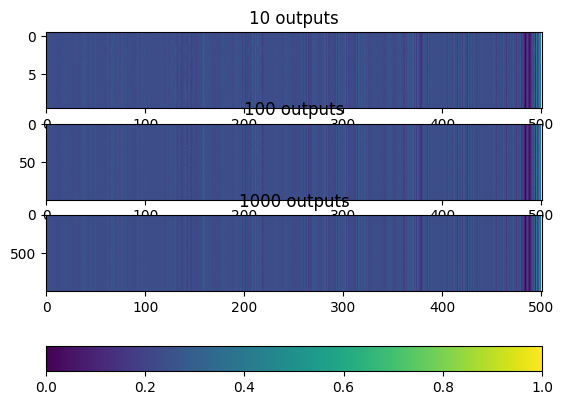

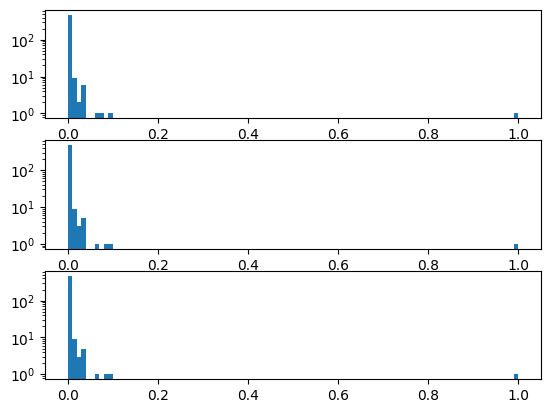

In [107]:
deep_linear2 = DeepLinear(4, 1, hidden=5, hidden_size=10)

plot_dots_stats(
    deep_linear2,
    [
        random_batch(10, 4),
        random_batch(100, 4),
        random_batch(1000, 4)
    ]
)

Parameters in model: 492


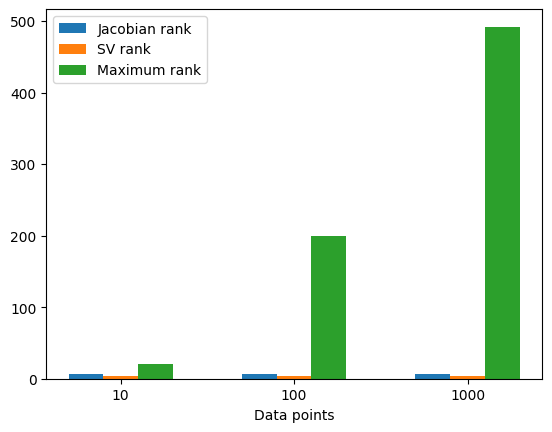

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axs2 = [axs2]
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


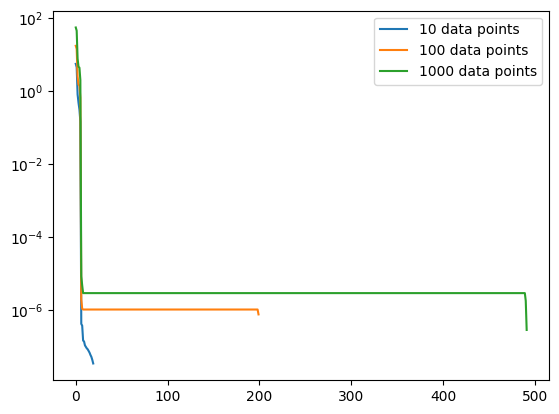

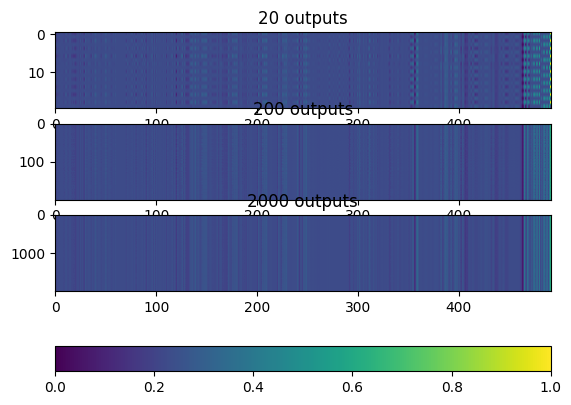

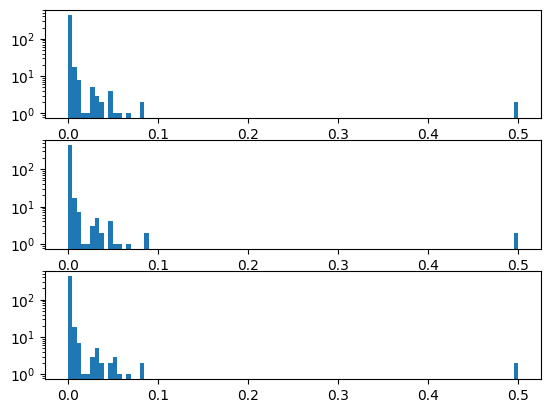

In [108]:
deep_linear3 = DeepLinear(2, 2, hidden=5, hidden_size=10)

plot_dots_stats(
    deep_linear3,
    [
        random_batch(10, 2),
        random_batch(100, 2),
        random_batch(1000, 2)
    ]
)